In [7]:
# TODO: rewrite so it does not rely on TM.
# Need to explain Pycellin data architecture in details.

# Getting started

In [2]:
from lxml import etree
import matplotlib.pyplot as plt
import networkx as nx
import tifffile

from pycellin.io.trackmate import load_TrackMate_XML, export_TrackMate_XML

# %matplotlib widget

## 1. Extracting graphs from TrackMate XMLs

The data we are using as example is a stack tif called `FakeTracks`. It is available in Fiji in File > Open samples > Tracks for TrackMate. \
After spot detection and tracking in TrackMate, a TrackMate XML has been saved. The raw image (in grayscale) as well as the result of the detection and tracking (in cyan and magenta) can be seen below.

(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x26b6eb661e0>)

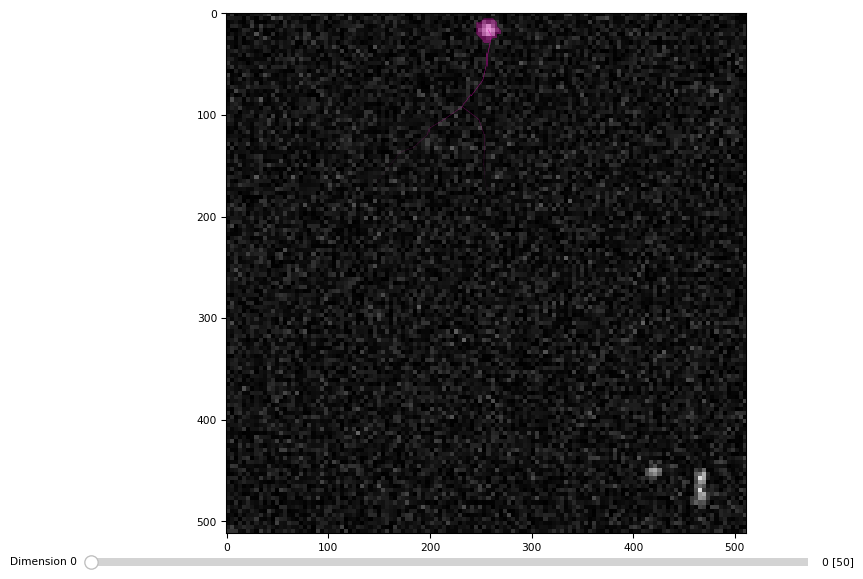

In [3]:
import tifffile

track_img = tifffile.imread("../sample_data/FakeTracks_TM_capture.tif")
tifffile.imshow(track_img)

In Pycellin, tracks from TrackMate are modeled by directed acyclic graphs and are called cell lineages. **It means that splitting events are allowed, they even are recommended if you want to take full advantage of this Python package. However, MERGING EVENTS ARE NOT SUPPORTED.** If you try to use Pycellin on a lineage with merging events, it may crash or produce incorrect results, especially if you are computing features related to tracking.

Currently, Pycellin is creating one lineage per TrackMate track. \
The arguments `keep_all_spots` and `keep_all_tracks` allow you to keep (value to `True`) or discard (value to `False`) spots/tracks that were filtered out in TrackMate. These arguments are false by default.

In [5]:
# Path to the TrackMate XML file.
xml_path = "../sample_data/FakeTracks.xml"

# Parse the XML file and create a Pycellin Model object
# that contains all the data from the XML file.
model = load_TrackMate_XML(xml_path)

# We can display basic information about this model.
print(model)
print(f"This model contains {model.data.number_of_lineages()} lineages:")
for lin_ID, lineage in model.data.cell_data.items():
    print(f"- ID {lin_ID}: {lineage}")

Model with 2 lineages.
This model contains 2 lineages:
- ID 0: CellLineage named 'Track_47' with 74 nodes and 73 edges
- ID 4: CellLineage named 'Track_51' with 10 nodes and 9 edges


So here we have two different cell lineages that you can identify by their ID: 0 and 4.

## 2. Lineage information

Thanks to networkX and pygraphviz dependencies, you can display lineages with the `plot()` method. The representation is similar to what TrackMate TrackScheme displays: one node per spot with its unique ID, and time (in frames) flows from top to bottom.

The first cell lineage, the magenta one, looks like this:

In [6]:
model.data.cell_data[0].plot()

And the cyan one like this:

In [7]:
model.data.cell_data[4].plot()

We can already see that there are 2 division events in the first lineage and none in the second.

To automatically identify the cells/nodes in division, we can use the `get_divisions()` function:


In [8]:
for id, lineage in model.data.cell_data.items():
    print(f"Divisions in lineage {id}: {lineage.get_divisions()}")

Divisions in lineage 0: [2015, 2030]
Divisions in lineage 4: []


We can similarly identify the first cell of the lineage (root of the graph) and the last cells (leaves of the graph):

In [9]:
print(f"First cell: {model.data.cell_data[0].get_root()}")
print(f"Last cells: {model.data.cell_data[0].get_leaves()}")

First cell: 2004
Last cells: [2064, 2070, 2095]


To check if a node is a root, a leaf or a division, we can use the `is_root()`, `is_leaf()` or `is_division()` respectively:

In [10]:
node_ID = 2030
print(model.data.cell_data[0].is_root(node_ID))
print(model.data.cell_data[0].is_leaf(node_ID))
print(model.data.cell_data[0].is_division(node_ID))

False
False
True


## 3. Accessing, computing and adding features

### 3.1 TrackMate features

All the features available in TrackMate are stored in our lineage graphs under identical names:
- spot features like AREA are stored as node attributes;
- link features like LINK_COST are stored as edge attributes;
- track features like TRACK_DISPLACEMENT are stored as graph attributes.

Since lineage graphs are implemented in pycellin as networkX directed graphs, you can access any attribute like in any other networkX graph (cf [networkX tutorial](https://networkx.org/documentation/stable/tutorial.html)).

For node attributes, here is an example for node 2015 which is the first division event in our first graph (magenta).

In [9]:
# All the information on node 2015.
graphs[0].nodes[2015]

{'ID': 2015,
 'name': 'ID2015',
 'STD_INTENSITY_CH1': 78.47237121100814,
 'SOLIDITY': 0.9038461538461539,
 'QUALITY': 0.6568132638931274,
 'POSITION_T': 8.0,
 'TOTAL_INTENSITY_CH1': 3168.0,
 'CONTRAST_CH1': 0.6741926778807231,
 'ELLIPSE_MINOR': 2.699594497902885,
 'ELLIPSE_THETA': 0.7027771698359253,
 'ELLIPSE_Y0': 0.07260987685983139,
 'FRAME': 8,
 'CIRCULARITY': 0.66512709023486,
 'AREA': 23.5,
 'ELLIPSE_MAJOR': 2.848288104303809,
 'MEAN_INTENSITY_CH1': 131.99999999999997,
 'MAX_INTENSITY_CH1': 253.0,
 'MIN_INTENSITY_CH1': 12.0,
 'SNR_CH1': 1.354770540216263,
 'ELLIPSE_X0': -0.002535846121074888,
 'MEDIAN_INTENSITY_CH1': 144.0,
 'VISIBILITY': 1,
 'RADIUS': 2.7350104799285653,
 'POSITION_X': 57.53900709219859,
 'POSITION_Y': 22.602836879432623,
 'ELLIPSE_ASPECTRATIO': 1.0550799783139404,
 'POSITION_Z': 0.0,
 'PERIMETER': 21.071067811865476,
 'ROI_N_POINTS': [(2.460992907801412, -0.6028368794326227),
  (3.460992907801412, 0.39716312056737735),
  (2.460992907801412, 0.39716312056737735)

In [10]:
# Just the info of a specific attribute.
graphs[0].nodes[2015]["AREA"]

23.5

You can also list all the available nodes attributes with:

In [11]:
import pycellin.graph.features as feat

feat.get_node_attributes_names(graphs[0])

['ID',
 'name',
 'STD_INTENSITY_CH1',
 'SOLIDITY',
 'QUALITY',
 'POSITION_T',
 'TOTAL_INTENSITY_CH1',
 'CONTRAST_CH1',
 'ELLIPSE_MINOR',
 'ELLIPSE_THETA',
 'ELLIPSE_Y0',
 'FRAME',
 'CIRCULARITY',
 'AREA',
 'ELLIPSE_MAJOR',
 'MEAN_INTENSITY_CH1',
 'MAX_INTENSITY_CH1',
 'MIN_INTENSITY_CH1',
 'SNR_CH1',
 'ELLIPSE_X0',
 'MEDIAN_INTENSITY_CH1',
 'VISIBILITY',
 'RADIUS',
 'POSITION_X',
 'POSITION_Y',
 'ELLIPSE_ASPECTRATIO',
 'POSITION_Z',
 'PERIMETER',
 'ROI_N_POINTS',
 'TRACK_ID']

### 3.2 Pycellin features

A few additional features are already implemented in pycellin.
They can be divided into 2 categories: morphological features and tracking features.

**Morphological features:**
- WIDTH
- LENGTH

These features are useful when the objects that have been tracked are elongated (e.g. *E. coli*).
They are computed both at the same time and rely on a skeletonization of the tracked objects.

To compute the width and length of the region of interest (ROI) of a specific node:

In [12]:
# Pixel size must be in micrometer.
width, length = feat.width_and_length(graphs[0], node=2030, pixel_size=1)
print(width, length)

3.7096634014973198 6.82842712474619


Currently, if the ROI is too round and yields an improper skeleton, a warning will be displayed and width and length will be set to NaN. \
This will be changed at some point in favor of returning a warning and a float value.

In [13]:
# Width and length are not a good metric to characterize a roundish object.
width, length = feat.width_and_length(graphs[0], node=2015, pixel_size=1)
print(width, length)

nan nan


To not only compute width and length but also add these features to all the nodes of a graph, we can use the `add_width_and_length()` function. \
This function keeps the graph coherency and ensures TrackMate compatibility by updating the `Model` graph attribute with the new feature name and dimension.

In [14]:
# Calling `add_width_and_length()` on each graph to update everything.
for graph in graphs:
    feat.add_width_and_length(graph, pixel_size=1)

# The new features are now available:
print(graphs[0].nodes[2030]["WIDTH"])
print(graphs[0].nodes[2030]["LENGTH"])

3.7096634014973198
6.82842712474619


**Tracking features:**
- ABSOLUTE_AGE: age relative to the root/first cell;
- RELATIVE_AGE: age relative to the birth of the current generation (previous division or the root);
- DIV_TIME: division time (time between 2 divisions), in frames;
- GEN_LVL: generation level i.e. number of divisions upstream;
- GEN_COMPLETE: completeness of the generation (if a generation includes the root or a leaf, it is not complete);
- GEN_ID: generation ID given by '{TRACK_ID}_{NODE_ID of the last node of the generation}', last node being either a division or a leaf;
- CELL_PHASE: cell cycle phase.

A generation is defined as the track segment between 2 divisions, excluding the first division but including the last one.

Like morphological features, it is possible to either compute pycellin features or add them to a lineage thanks to the following functions:
| Feature name | Func. to compute feat. | Func. to add feat. | Can be injected into TrackMate |
| --- | --- | --- | --- |
| ABSOLUTE_AGE | absolute_age() | add_absolute_age() | Yes |
| RELATIVE_AGE | relative_age() | add_relative_age() | Yes |
| DIV_TIME | division_time() | add_division_time() | Yes |
| GEN_LVL | generation_level() | add_generation_level() | Yes |
| GEN_COMPLETE | generation_completeness() | add_generation_completeness() | Yes |
| GEN_ID | generation_ID() | add_generation_ID() | Not currently |
| CELL_PHASE | cell_phase() | add_cell_phase() | Not currently |

For example we can add ABSOLUTE_AGE and RELATIVE_AGE to all our graphs.

In [15]:
for graph in graphs:
    feat.add_absolute_age(graph)
    feat.add_relative_age(graph)

Now if we list all the current node features of a graph, we can see the recently added ones at the end:

In [16]:
feat.get_node_attributes_names(graphs[0])

['ID',
 'name',
 'STD_INTENSITY_CH1',
 'SOLIDITY',
 'QUALITY',
 'POSITION_T',
 'TOTAL_INTENSITY_CH1',
 'CONTRAST_CH1',
 'ELLIPSE_MINOR',
 'ELLIPSE_THETA',
 'ELLIPSE_Y0',
 'FRAME',
 'CIRCULARITY',
 'AREA',
 'ELLIPSE_MAJOR',
 'MEAN_INTENSITY_CH1',
 'MAX_INTENSITY_CH1',
 'MIN_INTENSITY_CH1',
 'SNR_CH1',
 'ELLIPSE_X0',
 'MEDIAN_INTENSITY_CH1',
 'VISIBILITY',
 'RADIUS',
 'POSITION_X',
 'POSITION_Y',
 'ELLIPSE_ASPECTRATIO',
 'POSITION_Z',
 'PERIMETER',
 'ROI_N_POINTS',
 'TRACK_ID',
 'WIDTH',
 'LENGTH',
 'ABSOLUTE_AGE',
 'RELATIVE_AGE']

### 3.3 Custom features

If you want to compute your own features, pycellin has a `add_custom_attr()` function to help you.

Here is a quick example that adds a `NODE_ID_PARITY` feature to each node, with a value of 0 if the node ID is an even number and a value of 1 if it is an odd number. Of course this is a silly little example, but you can build on it to compute more complex new features.

In [17]:
# First we define a function that computes the new feature and adds it to
# all the nodes of a given graph.
def add_node_ID_parity(graph):
    for node in graph.nodes():
        if node % 2 == 0:
            graph.nodes[node]["NODE_ID_PARITY"] = 0
        else:
            graph.nodes[node]["NODE_ID_PARITY"] = 1

In [18]:
# Then we call this function as an argument in add_custom_attr().
for graph in graphs:
    feat.add_custom_attr(
        graph,  # graph to update
        "node",  # what is updated in the graph? node, edge or track?
        "NODE_ID_PARITY",  # feature name in the graph
        "Node ID parity",  # real name
        "Node ID parity",  # shortname
        "NONE",  # dimension of the feature: time, velocity, position...?
        "true",  # is this feature an int?
        add_node_ID_parity,  # function that add the new feature
        graph,  # argument(s) of the function that computes the new feature
    )

Another way to do it is to use the `apply_on_nodes()` function in conjonction with `add_custom_attr()`. \
`apply_on_nodes()` takes a function that computes a new feature on a given node as argument, and uses it to update all the nodes of a graph. \
In that case, our previous example is written as follow.

In [19]:
# Function that computes the new feature on a given node but DOES NOT update the graph.
def get_node_ID_parity(graph, node):
    if graph.nodes[node]["ID"] % 2 == 0:
        return 0
    else:
        return 1


# Then we update the graphs all in one go.
for graph in graphs:
    feat.add_custom_attr(
        graph,
        "node",
        "NODE_ID_PARITY",
        "Node ID parity",
        "Node ID parity",
        "NONE",
        "true",
        feat.apply_on_nodes,  # function to apply another function to all the nodes
        graph,
        "NODE_ID_PARITY",
        get_node_ID_parity,  # function that computes a feature on a given node
    )

If the new feature is an integer, a float or a boolean, using `add_custom_attr()` ensures that TrackMate will be able to read the feature correctly.

We can check that this custom feature is present:

In [20]:
assert "NODE_ID_PARITY" in feat.get_node_attributes_names(graphs[0])
print(graphs[0].nodes[2015]["NODE_ID_PARITY"])
print(graphs[0].nodes[2030]["NODE_ID_PARITY"])

1
0


## 4. Going back to TrackMate

Now that we have added a few pycellin and custom features to our lineage graphs, we want to go back to TrackMate so we can display and filter on these new features.

Currently, TrackMate settings are not stored inside the graphs. However these settings are needed to create a proper TrackMate XML so we need to have access to them. This is done with the `read_settings()` function.

In [21]:
from pycellin.tmio import read_settings

# Path to the original XML.
input_xml = "../sample_data/FakeTracks.xml"

settings = read_settings(input_xml)

By curiosity, we can check what information are in these settings:

In [22]:
from lxml import etree

print(etree.tostring(settings, pretty_print=True, encoding=str))

<Settings>
    <ImageData filename="FakeTracks.tif" folder="" width="128" height="128" nslices="1" nframes="50" pixelwidth="1.0" pixelheight="1.0" voxeldepth="1.0" timeinterval="1.0"/>
    <BasicSettings xstart="0" xend="127" ystart="0" yend="127" zstart="0" zend="0" tstart="0" tend="49"/>
    <DetectorSettings DETECTOR_NAME="STARDIST_DETECTOR" TARGET_CHANNEL="1"/>
    <InitialSpotFilter feature="QUALITY" value="0.4237962850817928" isabove="true"/>
    <SpotFilterCollection>
      <Filter feature="AREA" value="49.86274509803923" isabove="false"/>
    </SpotFilterCollection>
    <TrackerSettings TRACKER_NAME="SPARSE_LAP_TRACKER" CUTOFF_PERCENTILE="0.9" ALTERNATIVE_LINKING_COST_FACTOR="1.05" BLOCKING_VALUE="Infinity">
      <Linking LINKING_MAX_DISTANCE="10.0">
        <FeaturePenalties/>
      </Linking>
      <GapClosing ALLOW_GAP_CLOSING="true" GAP_CLOSING_MAX_DISTANCE="10.0" MAX_FRAME_GAP="2">
        <FeaturePenalties/>
      </GapClosing>
      <TrackSplitting ALLOW_TRACK_SPLITTING

They hold a lot of information about the image itself, the detector and tracker used, and the filters that were applied on nodes and tracks. This is why these settings are mandatory to create an XML readable by TrackMate.

Now that we have these settings, we can create our updated XML.

In [23]:
from pycellin.tmio import write_TrackMate_XML

# Path for saving the new XML.
output_xml = "../sample_data/FakeTracks_updated.xml"

write_TrackMate_XML(graphs, settings, output_xml)

If we open this updated XML in TrackMate, we can see that our new features are there and can be used as any other TrackMate feature, e.g. filtering (left window in the image below).

![](./imgs/custom_feat_in_TM.png)

## 5. TrackMate $ \Leftrightarrow $ pycellin by CLI

### 5.1 TrackMate $\Rightarrow$ pycellin


To extract graph(s) from a TrackMate XML via CLI, we execute the `xml2graph` python script, located in the `tmio` pycellin sub-package.
This script has only one mandatory argument: the path of the XML file to process.

Let's use our previous example, the `FakeTracks.xml`.

In [24]:
%%bash

# This is a Linux example.
xml2graph="../pycellin/tmio/xml2graph.py"  # Path to the xml2graph script.
xml_file="../sample_data/FakeTracks.xml"  # Path to the XML file to process.

$xml2graph $xml_file

Starting conversion...
...done in 0 min 0.01 s.
2 tracks have been exported.


The output is one .gz file per track. They are saved in the folder of the XML file.

![](./imgs/fe_xml2graph.png)

There are also a few optional arguments:
- `-h` to access the help information;
- `-s` to include in the graph the spots/bacteria filtered out in TrackMate;
- `-t` to include in the graph the tracks/lineages filtered out in TrackMate;
- `-p` to display each track, one by one. Will be slower, especially with large graphs;
- `-o` to export a unique graph containing all the tracks instead of multiple graphs, one per track. Useful when there is no tracking but you still want to use pycellin for node analysis.

For example, if we want to keep all the spots and tracks that were filtered out in TrackMate:

In [25]:
%%bash

# This is a Linux example.
xml2graph="../pycellin/tmio/xml2graph.py"
xml_file="../sample_data/FakeTracks.xml"

$xml2graph $xml_file -st

Starting conversion...
...done in 0 min 0.01 s.
18 tracks have been exported.


In this case, there will be one .gz file per track (*\*\_Track\_\*.gz*), as well as one per node not assigned to a track (*\*\_Node\_\*.gz*).

![](./imgs/fe_xml2graph_st.png)

### 5.2 Reading/writing graphs from/on disk

Once the graphs are saved on disk, it is possible to open them in Python for further processing (cf section 2 & 3).

We can either load graphs one by one with `load_graph()`:

In [26]:
from pycellin.graph import io

graph_path = "../sample_data/FakeTracks_Track_47.gz"
graph = io.load_graph(graph_path)
print(graph)

DiGraph named 'Track_47' with 74 nodes and 73 edges


Or load all the .gz file of a folder with `load_graphs()`:

In [27]:
xml_folder = "../sample_data/"
graphs, files = io.load_graphs(xml_folder)
for g, f in zip(graphs, files):
    print(f"{g}\t{f}")

DiGraph with 1 nodes and 0 edges	../sample_data/FakeTracks_Node_2012.gz
DiGraph with 1 nodes and 0 edges	../sample_data/FakeTracks_Node_2018.gz
DiGraph with 1 nodes and 0 edges	../sample_data/FakeTracks_Node_2037.gz
DiGraph with 1 nodes and 0 edges	../sample_data/FakeTracks_Node_2069.gz
DiGraph with 1 nodes and 0 edges	../sample_data/FakeTracks_Node_2073.gz
DiGraph with 1 nodes and 0 edges	../sample_data/FakeTracks_Node_2082.gz
DiGraph with 1 nodes and 0 edges	../sample_data/FakeTracks_Node_2086.gz
DiGraph with 1 nodes and 0 edges	../sample_data/FakeTracks_Node_2094.gz
DiGraph with 1 nodes and 0 edges	../sample_data/FakeTracks_Node_2098.gz
DiGraph with 1 nodes and 0 edges	../sample_data/FakeTracks_Node_2101.gz
DiGraph with 1 nodes and 0 edges	../sample_data/FakeTracks_Node_2104.gz
DiGraph named 'Track_47' with 74 nodes and 73 edges	../sample_data/FakeTracks_Track_47.gz
DiGraph named 'Track_48' with 2 nodes and 1 edges	../sample_data/FakeTracks_Track_48.gz
DiGraph named 'Track_49' with 

After the processing is done, we can save the updated graphs back on disk.

We can do it either by specifying how to name the graph and where to save it:

In [28]:
output_graph_path = "../sample_data/my_new_graph.gz"
io.save_graph(graph, output_graph_path)

Or with an automated and consistent way of naming that relies on the original XML file:

In [29]:
xml_file = "../sample_data/FakeTracks.xml"
output_graph_path = io.export_graph(graph, xml_file)
print(output_graph_path)

../sample_data/FakeTracks_Track_47.gz


In that case the graph is saved in the same folder as the original XML.

### 5.3 pycellin $\Rightarrow$ TrackMate

To convert graphs into an XML file via CLI, we use the `graph2xml` script, also located in the `tmio` pycellin sub-package. This script has 3 mandatory arguments and no options.

In [30]:
%%bash

# This is a Linux example.
graph2xml="../pycellin/tmio/graph2xml.py"  # Path to the graph2xml script.
graphs_folder="../sample_data/"  # Folder holding the graphs to convert.
input_xml="../sample_data/FakeTracks.xml"   # Path to the original XML file.
output_xml="../sample_data/FakeTracks_written.xml"  # Where to save the new XML.

$graph2xml $graphs_folder $input_xml $output_xml

Starting conversion...
...done in 0 min 0.03 s.
19 graphs have been exported in a TrackMate xml file.


Regardless of the number of graphs given to `graph2xml`, only one XML file will be created.

Instead of giving a folder containing graphs as argument, it is also possible to pass a unique graph file:

In [31]:
%%bash

# This is a Linux example.
graph2xml="../pycellin/tmio/graph2xml.py" 
graph_path="../sample_data/FakeTracks_Track_47.gz"  # Path of the graph to convert.
input_xml="../sample_data/FakeTracks.xml"
output_xml="../sample_data/FakeTracks_Track_47.xml"

$graph2xml $graph_path $input_xml $output_xml

Starting conversion...
...done in 0 min 0.01 s.
1 graph has been exported in a TrackMate xml file.
